# What is the doggest dog?

This is a notebook that can be used to perform experiments connected to our paper.

The aim of our method is to visualize the typicality of all elements of a given basic-level category. Our methods aim to examine deep learning models from the perspective of the Prototype Theory.

Method from the paper: Strategy 3 (based Multidimensional Scaling)

In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications.imagenet_utils import decode_predictions

We use the following function to find the hyponyms for a given basic-level category - hypernym:

In [2]:
def find_hyponyms(hypernym_name):
    """
    Function ca be used to obtain a list of indexes of the ImageNet classes 
    belonging to a given basic-level category (a hypernym).
    ------
    Pramaters: 
    
    hypernym_name: a desired hypernym (e.g. "domestic_cat")
    """
    from nltk.corpus import wordnet as wn
    import nltk
    from tensorflow.keras.applications.imagenet_utils import decode_predictions
    from tensorflow.keras.utils import to_categorical
    import numpy as np
    
    hyponyms = wn.synsets(hypernym_name)[0]
    hyponyms = set([i for i in hyponyms.closure(lambda s:s.hyponyms())])
    offsets = []
    imagenet_classes = decode_predictions(to_categorical(np.expand_dims(np.array(range(1000)), axis=-1), num_classes=1000), top=1)

    for c in imagenet_classes:
        offsets.append(int(c[0][0].split('n')[1]))
    
    ids = []
    for idx, o in enumerate(offsets):
        isadoggo = wn.synset_from_pos_and_offset('n', int(o))
        if isadoggo in hyponyms:
            ids.append(idx)
    return np.array(ids)

In [3]:
def return_MDS_coordinates_and_classes(weights, hyponym_classes, random_state):
    """
    Function can be used to embed ImageNet classes (Described via hidden 
    network representations - weights) in a 2D space via Multidimensional Scaling.
    ------
    Parameters: 
    
    weights: extracted weights of categories of interest (+ a central element obtained as 
    an element-wise avg of all weights)
    hyponym_classes: indexes of hyponyms (ImageNet classes to be embedded).
    random_state: number used for MDS initialization (of points in MDS' 2D space).
    """
    from sklearn.manifold import MDS
    from sklearn.metrics.pairwise import cosine_distances
    from sklearn.metrics.pairwise import euclidean_distances
    
    cosine_distances = cosine_distances(weights)
    embedding = MDS(n_components=2, normalized_stress='auto', dissimilarity='precomputed', random_state=random_state)
    X_transformed = embedding.fit_transform(cosine_distances)
    return X_transformed, hyponym_classes

In [4]:
def return_MDS_visualization(model, hypernym_name, keras=True, levit=False, random_state=0):
    """
    Function can be used to find prototypes and anti-prototypes for a given basic-level category 
    for a given deep learning model. 
    Parameters: 
    model: keras/torch model trained on ImageNet (with a standard order of classes that can be decoded with 
    tensorflow.keras.applications.imagenet_utils.decode_predictions
    hypernym_name: string with a name of a basic-level category, e.g. "domestic_cat", "dog" etc.
    keras: flag whether we want to use a keras model (set True if yes - it is a default). 
    Set false in the case of using a torch model.
    levit: set with keras=False in the case of using one of the LeViTs models.
    random_state: number used for MDS initialization (of points ind MDS' 2D space).
    """
    hyponym_classes = find_hyponyms(hypernym_name=hypernym_name)
    
    if keras:
        hyponym_weights = np.moveaxis(model.layers[-1].get_weights()[0][:, hyponym_classes], -1, 0)
        hypernym_weights = np.mean(model.layers[-1].get_weights()[0][:, hyponym_classes], axis=1)
        hypernym_weights = np.expand_dims(hypernym_weights, axis=0)
        all_weights = np.concatenate([hyponym_weights, hypernym_weights], axis=0)
    else:
        if not levit:
            hyponym_weights = model.classifier.weight.detach().numpy()[hyponym_classes, :]
            hypernym_weights = np.mean(hyponym_weights, axis=0)
            hypernym_weights = np.expand_dims(hypernym_weights, axis=0)
            all_weights = np.concatenate([hyponym_weights, hypernym_weights], axis=0)
        else:
            hyponym_weights = model.classifier_distill.linear.weight.detach().numpy()[hyponym_classes, :]
            hypernym_weights = np.mean(hyponym_weights, axis=0)
            hypernym_weights = np.expand_dims(hypernym_weights, axis=0)
            all_weights = np.concatenate([hyponym_weights, hypernym_weights], axis=0)

    map_mds, ids = return_MDS_coordinates_and_classes(all_weights, hyponym_classes, random_state)
    return map_mds, ids

In [5]:
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
font = {'size'   : 10}

matplotlib.rc('font', **font)

sns.set(rc={'figure.figsize':(16, 10)}, font_scale=1.5) #set width and height

In [6]:
# first, we generate the graphical results for ConvNeXtSmall & bird category
model = tf.keras.applications.ConvNeXtSmall(
    include_top=True,
    weights="imagenet",
    input_tensor=None,
    input_shape=None,
    pooling='avg',
    classes=1000,
    classifier_activation="softmax",
)

hypernym_name = "bird"
print(model.name)
map_mds, ids = return_MDS_visualization(model=model, hypernym_name=hypernym_name, keras=True, random_state=55)

convnext_small


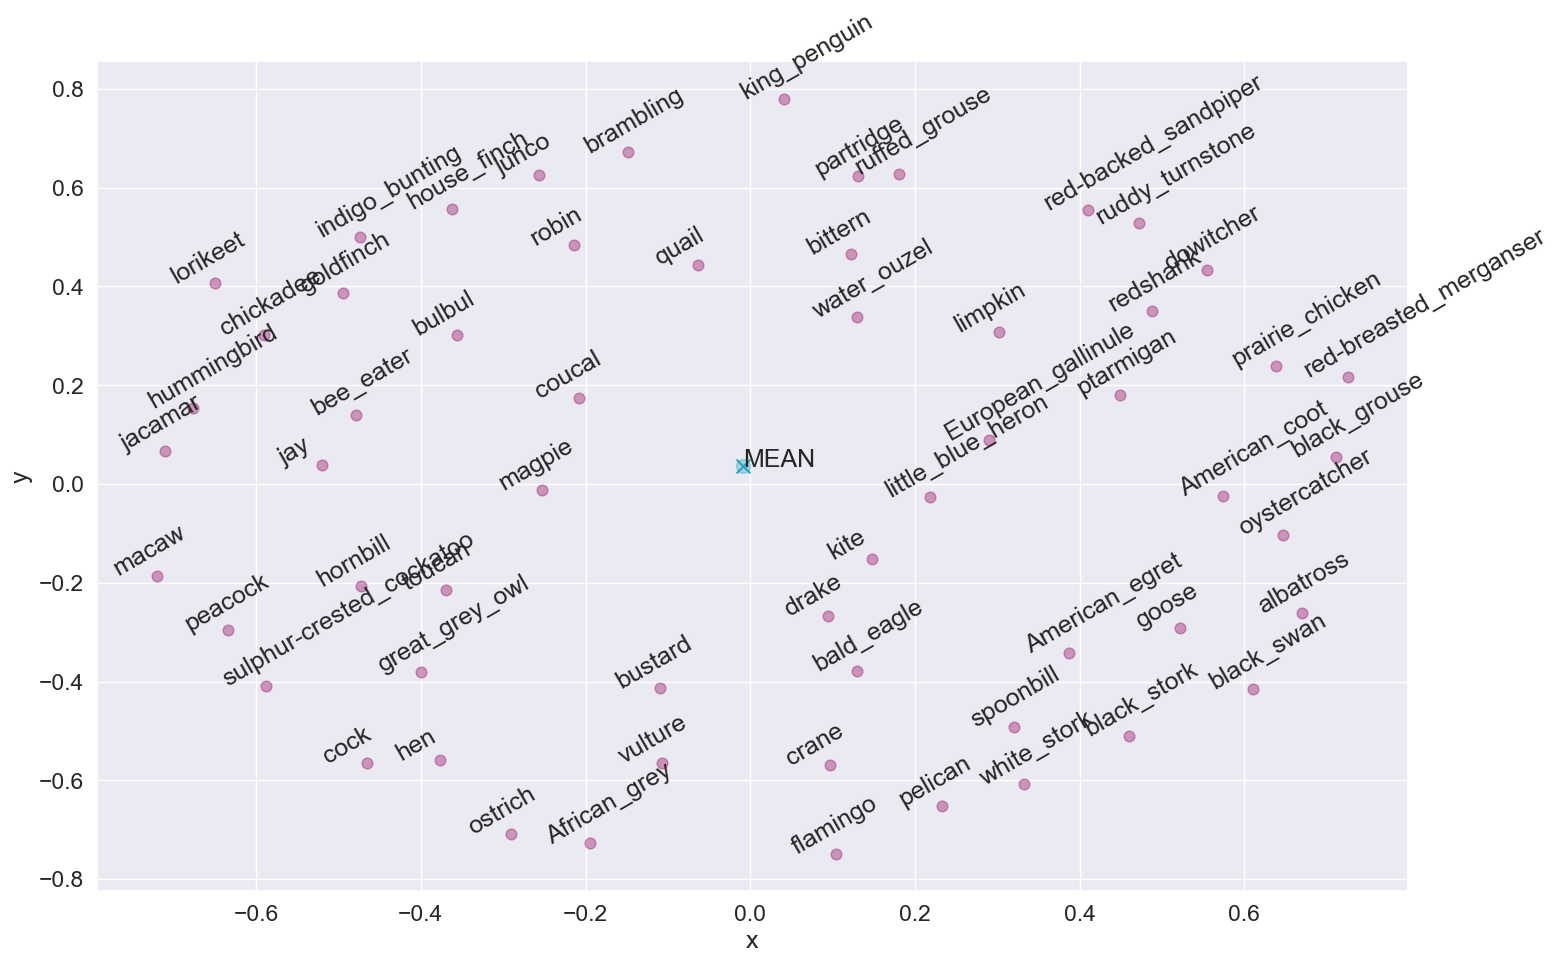

In [7]:
#visualization
shiftt = (np.max(map_mds[:, 0]) - np.min(map_mds[:, 0])) / 25
plt.scatter(map_mds[:-1, 0], map_mds[:-1, 1], c="#991166", s=60, alpha=0.4)
plt.scatter(map_mds[-1, 0], map_mds[-1, 1], c="#0099bb", s=100, alpha=0.8, marker='x')
plt.scatter(map_mds[-1, 0], map_mds[-1, 1], c="#0099bb", s=100, alpha=0.3, marker='o')
for i, txt in enumerate(ids):
    if i < len(ids):
        plt.annotate(decode_predictions(to_categorical([[txt]], num_classes=1000), top=1)[0][0][1], (map_mds[i, 0] - shiftt, map_mds[i, 1]), rotation=30)
plt.annotate('MEAN', (map_mds[len(ids), 0], map_mds[len(ids), 1]), rotation=0)
plt.xlabel('x')
plt.ylabel('y')
plt.tight_layout()
plt.show()

In [8]:
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
font = {'size'   : 10}

matplotlib.rc('font', **font)

sns.set(rc={'figure.figsize':(8, 5)}, font_scale=1.5) #set width and height

In [ ]:
# we generate the graphical results for InceptionV3 & fish category

model = tf.keras.applications.InceptionV3(
    include_top=True,
    weights="imagenet",
    input_tensor=None,
    input_shape=None,
    pooling='avg',
    classes=1000,
    classifier_activation="softmax",
)

hypernym_name = "fish"

print(model.name)
map_mds, ids = return_MDS_visualization(model=model, hypernym_name=hypernym_name, keras=True, random_state=77)

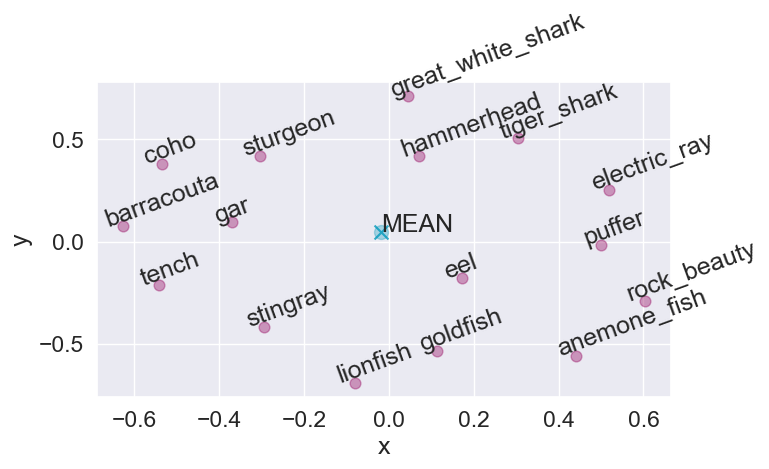

In [10]:
# visualization:
shiftt = (np.max(map_mds[:, 0]) - np.min(map_mds[:, 0])) / 25
plt.scatter(map_mds[:-1, 0], map_mds[:-1, 1], c="#991166", s=60, alpha=0.4)
plt.scatter(map_mds[-1, 0], map_mds[-1, 1], c="#0099bb", s=100, alpha=0.8, marker='x')
plt.scatter(map_mds[-1, 0], map_mds[-1, 1], c="#0099bb", s=100, alpha=0.3, marker='o')
for i, txt in enumerate(ids):
    if i < len(ids):
        plt.annotate(decode_predictions(to_categorical([[txt]], num_classes=1000), top=1)[0][0][1], (map_mds[i, 0] - shiftt, map_mds[i, 1]), rotation=20)
plt.annotate('MEAN', (map_mds[len(ids), 0], map_mds[len(ids), 1]), rotation=0)
plt.xlabel('x')
plt.ylabel('y')
plt.tight_layout()
plt.show()

In [ ]:
# we generate the graphical results for swinv2-small-patch4-window16-256 & fish category

from transformers import AutoModelForImageClassification

name = "microsoft/swinv2-small-patch4-window16-256"
model = AutoModelForImageClassification.from_pretrained(name)

hypernym_name = "fish"

print(model.__class__.__name__)
map_mds, ids =  return_MDS_visualization(model=model, hypernym_name=hypernym_name, keras=False, random_state=77)

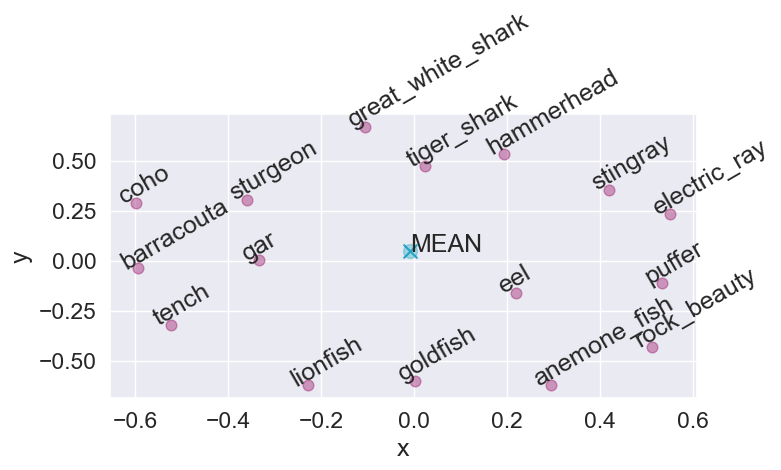

In [12]:
# visualization:
shiftt = (np.max(map_mds[:, 0]) - np.min(map_mds[:, 0])) / 25
plt.scatter(map_mds[:-1, 0], map_mds[:-1, 1], c="#991166", s=60, alpha=0.4)
plt.scatter(map_mds[-1, 0], map_mds[-1, 1], c="#0099bb", s=100, alpha=0.8, marker='x')
plt.scatter(map_mds[-1, 0], map_mds[-1, 1], c="#0099bb", s=100, alpha=0.3, marker='o')
for i, txt in enumerate(ids):
    if i < len(ids):
        plt.annotate(decode_predictions(to_categorical([[txt]], num_classes=1000), top=1)[0][0][1], (map_mds[i, 0] - shiftt, map_mds[i, 1]), rotation=30)
plt.annotate('MEAN', (map_mds[len(ids), 0], map_mds[len(ids), 1]), rotation=0)
plt.xlabel('x')
plt.ylabel('y')
plt.tight_layout()
plt.show()